# Clustering through word2vec embeddings

In [6]:
import pandas as pd
import numpy as np
import tqdm

In [7]:
import gensim
from gensim.models import KeyedVectors

from sklearn.base import TransformerMixin
from sklearn.manifold import TSNE

from sklearn.cluster import DBSCAN

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Let's just take not a very large pretrained word embeddings
# For better performance I suggest to use fastText.

import os

if not os.path.exists('data/18.zip'):
  !wget http://vectors.nlpl.eu/repository/11/18.zip -O data/18.zip

if not os.path.exists('data/model.txt'):
  !cd data ;unzip 18.zip


In [10]:
w2v = KeyedVectors.load_word2vec_format('./data/model.txt')

In [11]:
class EmbeddingsVectorizer(TransformerMixin):
    def __init__( self, w2v ):
        self.word2vec = w2v 
        
    def fit(self, X, y=None):
        return self # Don't need to fit this 
    
    def _phrase_vector(self, text):
        vectors = [self.word2vec.get_vector(x) for x in text.split() if x in self.word2vec.vocab]
        if len(vectors) == 0:
            return np.zeros(self.word2vec.vector_size)
        return np.mean(vectors, axis=0)
    
    #Method that describes what we need this transformer to do
    def transform(self, X, y=None):
        return np.stack(list(map(self._phrase_vector, X)))

In [12]:
ev = EmbeddingsVectorizer(w2v)

In [13]:
df = pd.read_csv('./data/cleaned_items.csv').fillna("")

In [14]:
sample_df = df.sample(1000)

In [15]:
sample_names = sample_df.clean_name

In [16]:
vectors = ev.fit_transform(sample_names)

In [204]:
X_embedded = TSNE(n_components=2, perplexity=50).fit_transform(vectors)

In [205]:
sample_df['x_plot'] = X_embedded[:, 0]
sample_df['y_plot'] = X_embedded[:, 1]

sample_labels = sample_df.sample(40)

In [20]:
sample_size = sample_df.shape[0]
matrix = np.zeros((sample_size, sample_size))

In [134]:
for i in tqdm.tqdm(range(sample_size)):
    text_i = sample_df.iloc[i].clean_name.split()
    for j in range(i, sample_size):
        text_j = sample_df.iloc[j].clean_name.split()
        dist = w2v.wmdistance(text_i, text_j)
        matrix[i,j] = dist
        matrix[j,i] = dist

100%|██████████| 1000/1000 [04:39<00:00,  3.58it/s]


In [135]:
matrix[matrix > 1000] = 1000

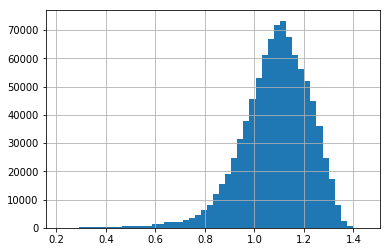

In [192]:
pd.Series(matrix[(matrix < 100) & (matrix > 0.001)]).hist(bins=50)  # define DBSCAN's eps param from this graph

In [184]:
clusterer = DBSCAN(eps=0.5, metric='precomputed')

In [185]:
clusters = clusterer.fit_predict(X=matrix)

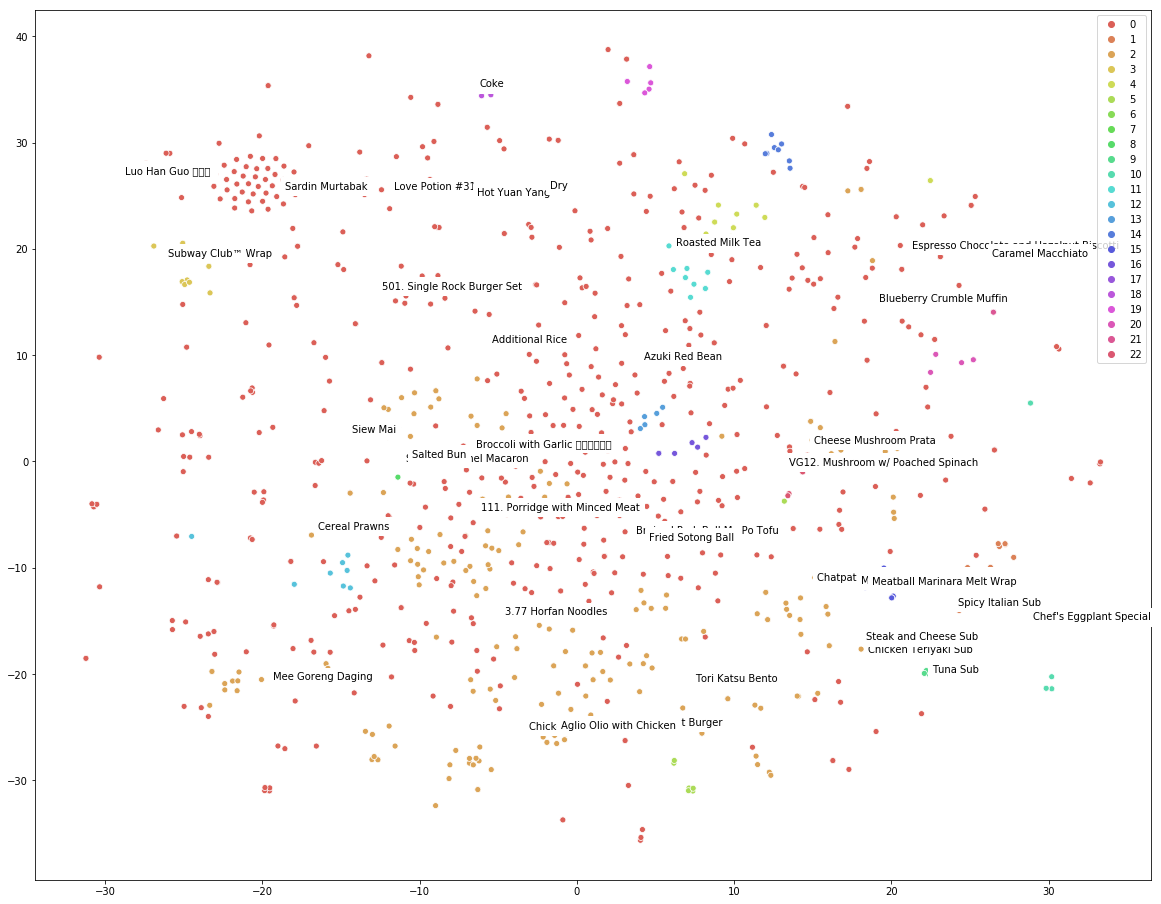

In [206]:
plt.figure(figsize=(20, 16))
pl = sns.scatterplot(
    x=X_embedded[:, 0],
    y=X_embedded[:, 1],
    hue=clusters_,
    palette=sns.color_palette("hls", max(clusters + 1) + 1)
)

for row in sample_labels.itertuples():
    pl.text(row.x_plot, row.y_plot, row.name, fontdict={'backgroundcolor': 'white'})

In [190]:
sample_df['cluster'] = clusters

In [196]:
sample_df[sample_df.cluster == 0]

product_id  vendor_id                     name  \
35355       35355        629       Spicy Italian Wrap   
35258       35258        650       Spicy Italian Wrap   
12014       12014        621   Bread - Hearty Italian   
12380       12380        624    Italian B.M.T.™ Salad   
35333       35333        632        Spicy Italian Sub   
11788       11788        615   Bread - Hearty Italian   
35615       35615        602      Spicy Italian Salad   
35380       35380        625  Spicy Italian Flatbread   
13283       13283        638   Bread - Hearty Italian   
35016       35016        572      Spicy Italian Salad   
14541       14541        656   Bread - Hearty Italian   
35018       35018        572      Spicy Italian Salad   
23317       23317       1024          Bread - Italian   
13279       13279        637          Bread - Italian   
26391       26391       1162      Italian B.M.T.™ Sub   

                                             description  \
35355  Spice up your life with a match between beef p...   
35258  Spice up your life with a match between beef p...   
12014                                                      
12380  An old world favourite made up of sliced beef ...   
35333  Spice up your life with a match between beef p...   
11788                                                      
35615  Spice up your life with a match between beef p...   
35380  Spice up your life with a match between beef p...   
13283                                                      
35016  Spice up your life with a match between beef p...   
14541                                                      
35018  Spice up your life with a match between beef p...   
23317                                                      
13279                                                      
26391  An old world favourite made up of sliced beef ...   

                    clean_name     x_plot     y_plot  cluster  
35355       spicy italian wrap -40.107998   6.187563        0  
35258       spicy italian wrap -40.108154   6.187658        0  
12014     bread hearty italian -44.975052   2.851292        0  
12380            italian salad -43.506813   4.380659        0  
35333        spicy italian sub -41.546364   9.682617        0  
11788     bread hearty italian -45.743423   3.081800        0  
35615      spicy italian salad -42.314426   4.384923        0  
35380  spicy italian flatbread -42.373508   5.520010        0  
13283     bread hearty italian -45.472435   2.659035        0  
35016      spicy italian salad -42.181908   4.557105        0  
14541     bread hearty italian -45.181664   3.241248        0  
35018      spicy italian salad -42.367699   4.584452        0  
23317            bread italian -45.680008   4.524234        0  
13279            bread italian -45.680008   4.524234        0  
26391              italian sub -41.594887  10.167425        0

Here we can see, that there are a lot of small clusters, derived from close popular product (like tea, pizza, e.t.c.) as well as merchant clusters (like Subway).

There is also a cluster of Italian foods, for example